### * \[important] This notebook is **only for Colab-execution**, please use colaboratory to test following codes.
### * \[important] Change runtime type to GPU first & execute following cells
### * Official Github repository & documents @ https://github.com/keras-team/keras-tuner
### * Keras-tuner Basic tutorial (TF official document) @ https://www.tensorflow.org/tutorials/keras/keras_tuner


<hr>

<br>

## 1. Install Keras-Tuner

In [1]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 4.3 MB/s 


* Following codes are tested under **Tensorflow==2.3.0 & KerasTuner==1.0.2**
* If some codes are not working, try install tf & kerastuner with above version.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import keras_tuner as kt

print(tf.__version__)
print(kt.__version__)

2.8.0
1.1.2


## -> Jump to section 3 (section 2 is just for additional knowledge)

11501568/11490434 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 dense (Dense)               (None, 20)                737300    
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                         

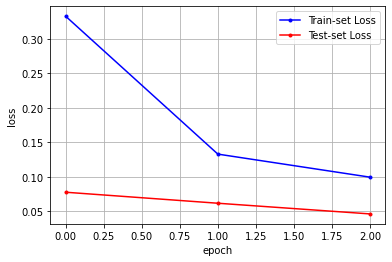

In [4]:
from tensorflow.keras import datasets, Sequential, utils
from tensorflow.keras.layers import Flatten, Conv2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# 1. Prepare & preprocess the data

(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255

y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)


# 2. Build the model

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.summary()


# 3. Fit the model & Visualize the result

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=3, batch_size=200)
print('\nAccuracy: {:.4f}'.format(model.evaluate(x_test, y_test)[1]))

y_vloss = history.history['val_loss']
y_loss = history.history['loss']


import numpy as np
import matplotlib.pyplot as plt

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")
plt.plot(x_len, y_vloss, marker='.', c='red', label="Test-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

<br>

## 3. Bayesian HPO with Keras-tuner

In [5]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow import keras 
from tensorflow.keras import layers

import keras_tuner as kt
import numpy as np
import IPython

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [6]:
pwd

'/content'

In [7]:
# 1) Prepare & preprocess the data


df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/train.csv')
df.drop(['index','FLAG_MOBIL'], axis = 1, inplace = True)
df.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,0,0,0,Managers,2.0,-26.0,2.0


In [8]:
df.gender = df.gender.replace({'F' : 0, 'M' : 1})
df.car = df.car.replace({'N' : 0, 'Y' : 1})
df.reality = df.reality.replace({'N' : 0, 'Y' : 1})
df.occyp_type = df.occyp_type.fillna('NaN')
df.head(3)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,0,0,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,0,0,0,NaN,2.0,-6.0,1.0
1,0,0,1,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,0,0,1,Laborers,3.0,-5.0,1.0
2,1,1,1,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,0,1,0,Managers,2.0,-22.0,2.0


In [9]:
df['age'] = df.DAYS_BIRTH.apply(lambda x : -x // 365)
df.DAYS_EMPLOYED = (-1) * df.DAYS_EMPLOYED 
df.loc[(df.DAYS_EMPLOYED < 0), 'DAYS_EMPLOYED'] = 0
df.begin_month = (-1) * df.begin_month

In [10]:
y = df.credit
X = df.drop(['credit', 'DAYS_BIRTH'], axis = 1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [12]:
numeric_features = ['child_num', 'income_total', 'DAYS_EMPLOYED', 'family_size', 'begin_month', 'age']
numeric_transformer = StandardScaler()

categorical_features = ['income_type', 'edu_type', 'family_type', 'house_type','occyp_type']
categorical_transformer = OneHotEncoder(categories='auto', handle_unknown = 'ignore')

# label_features = ['credit']
# label_transformer = LabelEncoder()

preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)
                ], remainder='passthrough'
                )

In [13]:
preprocessor.fit(X_train)
scaled_X_train = preprocessor.transform(X_train)
scaled_X_test = preprocessor.transform(X_test)

In [14]:
import tensorflow as tf
from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing

In [15]:
scaled_X_train = pd.DataFrame(scaled_X_train)
scaled_X_test = pd.DataFrame(scaled_X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

In [16]:
# 2) Build the hyper-model
# Available HyperParameter search spaces (https://j.mp/2IXPzh7) : Int, Float, Boolean, Choice, Fixed

def build_hyper_model(hp):
    
    model = keras.Sequential()
    model.add(layers.Flatten())
    # Tune the number of hidden layer (Choose an optimal value between 1~3)
    for layer_num in range(hp.Int('num_layers', min_value=1, max_value=3)): 
        # Tune the number of perceptrons in a dense layer (Choose an optimal value between 32~512) 
        hp_units = hp.Int('units_' + str(layer_num), min_value=scaled_X_train.shape[1], max_value=512, step=32) # 32:512 & step 32, all parameter names should be unique (we name the inner parameters 'units_' + str(i))
        hp_activations = hp.Choice('activation_' + str(layer_num), values=['relu', 'elu']) #choice는 문자열 후보[relu', 'elu']중 하나 고르는거 
        model.add(layers.Dense(units = hp_units, activation = hp_activations))

    model.add(layers.Dense(3, activation='softmax')) # class 10 : 0~9

    # Tune the learning rate for the optimizer (Choose an optimal value from 0.01, 0.001, or 0.0001)
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.categorical_crossentropy, # use sparse c.c when our labels are looks like "1" (single integer), not "[1,0,0]" (one-hot vector) (@ http://j.mp/2XS0jmv)
                metrics = ['accuracy'])
    
    return model

In [17]:
# 3) Select tuner and compile it
# Available tuners (https://j.mp/39cWz4n) : kt.BayesianOptimization / kt.Hyperband / kt.RandomSearch / kt.Sklearn (https://j.mp/3nSJn8O)

tuner = kt.BayesianOptimization(build_hyper_model,
                                objective = 'val_loss', # Hyper-params tuning을 위한 목적함수 설정 (metric to minimize or maximize)
                                max_trials = 10, # 서로 다른 Hyper-params 조합으로 시도할 총 Trial 횟수 설정
                                directory = 'test_prac_dir', # Path to the working directory
                                project_name = 'semi3_hyper_2') # Name to use as directory name for files saved by this Tuner

# tuner = kt.Hyperband(build_hyper_model,
#                      objective = 'val_accuracy', # Hyper-params tuning을 위한 목적함수 설정 (metric to minimize or maximize)
#                      max_epochs = 5, # 최대 epoch 수 설정, epoch 수 자체도 지정한 최대 횟수 내에서 변화시켜가며 테스트를 진행함 (epochs to train one model) 
#                      directory = 'test_prac_dir', # Path to the working directory
#                      project_name = 'MNIST_hyper_1') # Name to use as directory name for files saved by this Tuner

tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 52, 'max_value': 512, 'step': 32, 'sampling': None}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [18]:
# 4) Train the model

tuner.search(scaled_X_train, y_train, epochs=200, validation_data = (scaled_X_test, y_test)) # epochs == learning epoch for training a single model(epoch for each trial) 


# # 아래와 같이 별도의 클래스로 콜백을 정의하여 search 함수에서 활용하면 모든 학습 단계 종료 후 학습 중 발생한 출력 결과를 자동으로 지워낼 수 있습니다.
# class ClearTrainingOutput(tf.keras.callbacks.Callback):
#   def on_train_end(*args, **kwargs):
#     IPython.display.clear_output(wait = True)

# tuner.search(x_train, y_train, epochs = 7, validation_data = (x_test, y_test), callbacks = [ClearTrainingOutput()]) # epochs == learning epoch for training a single model 

Trial 10 Complete [00h 11m 22s]
val_loss: 0.8202070593833923

Best val_loss So Far: 0.8125104904174805
Total elapsed time: 01h 42m 42s


In [19]:
# 5) Check the result 

tuner.results_summary(num_trials=3) # Show "n" best trial results

Results summary
Results in test_prac_dir/semi3_hyper_2
Showing 3 best trials
Trial summary
Hyperparameters:
num_layers: 3
units_0: 500
activation_0: relu
learning_rate: 0.001
units_1: 84
activation_1: elu
units_2: 52
activation_2: relu
Score: 0.8125104904174805
Trial summary
Hyperparameters:
num_layers: 3
units_0: 500
activation_0: elu
learning_rate: 0.0001
units_1: 52
activation_1: elu
units_2: 52
activation_2: relu
Score: 0.8160402178764343
Trial summary
Hyperparameters:
num_layers: 2
units_0: 372
activation_0: elu
learning_rate: 0.001
units_1: 308
activation_1: elu
Score: 0.8195051550865173


In [20]:
# Check top-3 trials' hyper-params

top3_models = tuner.get_best_hyperparameters(num_trials=3)
# print(tuner.get_best_hyperparameters(num_trials=3)[0].space) # 특정 Trial의 Search-space 를 확인할 수 있음
# print(tuner.get_best_hyperparameters(num_trials=3)[0].values) # 특정 Trial에 적용된 Hyper-params를 확인할 수 있음

for idx, model in enumerate(top3_models):
    print('Model performance rank :', idx)
    print(model.values)
    print()


# Check the best trial's hyper-params

best_hps = top3_models[0]

print("""
The hyperparameter search is complete. 
* Optimal # of layers : {}
* Optimal value of the learning-rate : {}""".format(best_hps.get('num_layers'), best_hps.get('learning_rate')))

for layer_num in range(best_hps.get('num_layers')):
    print('Layer {} - # of Perceptrons :'.format(layer_num), best_hps.get('units_' + str(layer_num)))
    print('Layer {} - Applied activation function :'.format(layer_num), best_hps.get('activation_' + str(layer_num)))

Model performance rank : 0
{'num_layers': 3, 'units_0': 500, 'activation_0': 'relu', 'learning_rate': 0.001, 'units_1': 84, 'activation_1': 'elu', 'units_2': 52, 'activation_2': 'relu'}

Model performance rank : 1
{'num_layers': 3, 'units_0': 500, 'activation_0': 'elu', 'learning_rate': 0.0001, 'units_1': 52, 'activation_1': 'elu', 'units_2': 52, 'activation_2': 'relu'}

Model performance rank : 2
{'num_layers': 2, 'units_0': 372, 'activation_0': 'elu', 'learning_rate': 0.001, 'units_1': 308, 'activation_1': 'elu'}


The hyperparameter search is complete. 
* Optimal # of layers : 3
* Optimal value of the learning-rate : 0.001
Layer 0 - # of Perceptrons : 500
Layer 0 - Applied activation function : relu
Layer 1 - # of Perceptrons : 84
Layer 1 - Applied activation function : elu
Layer 2 - # of Perceptrons : 52
Layer 2 - Applied activation function : relu


In [21]:
# Get the best model from trials

models = tuner.get_best_models(num_models=3) # Keras Sequential models
top_model = models[0]
top_model.summary()
print()

results = top_model.evaluate(x_test, y_test)
print('Cross-entropy :', results[0])
print('Accuracy :', results[1])

ValueError: ignored

In [ ]:
# We can retrain the model with the optimal hyperparameters from the search.
best_hps = top3_models[0]

# Build the model with the optimal hyperparameters and train it on the data.
model = tuner.hypermodel.build(best_hps)
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

results = model.evaluate(x_test, y_test)
print('Cross-entropy :', results[0])
print('Accuracy :', results[1])

In [ ]:
# We can also find detailed logs, checkpoints, etc, in the folder "directory/project_name".

# The [test_prac_dir/MNIST_hyper_1] directory contains detailed logs and checkpoints for every trial (model configuration) run during the hyperparameter search. 
# If you re-run the hyperparameter search, the Keras Tuner uses the existing state from these logs to resume the search. 
# To disable this behavior, pass an additional [overwrite = True] argument while instantiating the tuner.

for trial in tuner.oracle.get_best_trials(num_trials=3):
    print('Trial-score is :', trial.score)
    print('Trial-directory(trial_id) is :', trial.trial_id)
    print()

# tuner.oracle.trials -> get all trial_id 

<br> 

## (Appendix) Use pre-trained models for computer vision: HyperResNet & HyperXception

* pre-compiled with loss='categorical_crossentropy' & metrics=\['accuracy']
* Next model-trainings take too much time, so try it if you are needed.

In [ ]:
from kerastuner.applications import HyperResNet, HyperXception
from kerastuner.tuners import Hyperband
from kerastuner import HyperParameters

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# (img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data() # if you want to use Fashion-MNIST instead of MNIST

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Prepare the data as needed
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

### Pre-trained ResNet

In [ ]:
hypermodel = HyperResNet(input_shape=(28, 28, 1), classes=10)

# Hyperband performs better than random search with low level computing resource. (Hyperband @ https://arxiv.org/abs/1603.06560)
tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=40,
    directory='test_prac_dir',
    project_name='MNIST_Resnet_1')

tuner.search(x_train, y_train, epochs=20, validation_data=(x_test, y_test))
tuner.results_summary()

### Pre-trained Xception

In [ ]:
hypermodel = HyperXception(input_shape=(28, 28, 1), classes=10)

# This will override the `learning_rate` parameter with your own selection of choices
hp = HyperParameters()
hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

# we can easily restrict the search space to just a few parameters
tuner = Hyperband(
    hypermodel,
    hyperparameters=hp, # ADDED
    tune_new_entries=False, # ADDED (`tune_new_entries=False` prevents unlisted parameters from being tuned)
    objective='val_accuracy',
    max_epochs=40,
    directory='test_prac_dir',
    project_name='MNIST_Xception_1')

tuner.search(x_train, y_train, epochs=20, validation_data=(x_test, y_test))
tuner.results_summary()

# What if you want to tune all available parameters in a hypermodel except the learning rate? @ https://j.mp/2J7jzHj

### Changing the existing optimizer, loss, or metrics

In [ ]:
hypermodel = HyperXception(input_shape=(28, 28, 1), classes=10)

tuner = Hyperband(
    hypermodel,
    optimizer=keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=[keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')],
    objective='mse',
    max_epochs=40,
    directory='test_prac_dir',
    project_name='MNIST_Xception_1')

tuner.search(x_train, y_train, epochs=20, validation_data=(x_test, y_test))
tuner.results_summary()

<br> 

## (Appendix) Additional materials 

* [Keras-Tuner official document](https://keras-team.github.io/keras-tuner/)
* [Keras Tuner on the TensorFlow blog](https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html)
* 
[**HParams Dashboard**](https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams) in TensorBoard to interactively tune model hyperparameters
